In [263]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
from sklearn.model_selection import GridSearchCV
import copy
from sklearn.ensemble import RandomForestClassifier

In [218]:

regdf = pd.read_csv("RegSeasonMod.csv")
regdf.head()

,Season,id,matchid,Daynum,team,Result,score,oppscore,loc,Numot,...,ftm,fta,or,dr,ast,to,stl,blk,pf,oppdr
0,2003,1,2003-1,10,1104,1,68,62,N,0,...,11,18,14,24,13,23,7,1,22,22
1,2003,2,2003-2,10,1272,1,70,63,N,0,...,10,19,15,28,16,13,4,4,18,25
2,2003,3,2003-3,11,1266,1,73,61,N,0,...,17,29,17,26,15,10,5,2,25,22
3,2003,4,2003-4,11,1296,1,56,50,N,0,...,17,31,6,19,11,12,14,2,18,20
4,2003,5,2003-5,11,1400,1,77,71,N,0,...,11,13,17,22,12,14,4,4,20,15


In [219]:
poss = pd.DataFrame(pd.pivot_table(regdf,values=('fga','or','to','fta'),index=('matchid'),aggfunc = sum)).reset_index()

In [220]:
# possesions
poss['poss'] = 0.96*(poss['fga']-poss['or']-poss['to']+(0.475*poss['fta']))

In [221]:
possessions = poss[['matchid','poss']].set_index('matchid')
possessions[:5]

,poss
matchid,
2003-1,62.400
2003-10,83.256
2003-100,71.424
2003-1000,74.400
2003-1001,69.216


In [222]:
regdf = regdf.join(possessions, on ='matchid',how='left',rsuffix = '_p')
regdf[:5]

,Season,id,matchid,Daynum,team,Result,score,oppscore,loc,Numot,...,fta,or,dr,ast,to,stl,blk,pf,oppdr,poss
0,2003,1,2003-1,10,1104,1,68,62,N,0,...,18,14,24,13,23,7,1,22,22,62.400
1,2003,2,2003-2,10,1272,1,70,63,N,0,...,19,15,28,16,13,4,4,18,25,84.024
2,2003,3,2003-3,11,1266,1,73,61,N,0,...,29,17,26,15,10,5,2,25,22,82.272
3,2003,4,2003-4,11,1296,1,56,50,N,0,...,31,6,19,11,12,14,2,18,20,52.656
4,2003,5,2003-5,11,1400,1,77,71,N,0,...,13,17,22,12,14,4,4,20,15,76.800


In [223]:
regdf.columns

Index(['Season', 'id', 'matchid', 'Daynum', 'team', 'Result', 'score',
       'oppscore', 'loc', 'Numot', 'fgm', 'fga', 'fgm3', 'fga3', 'ftm', 'fta',
       'or', 'dr', 'ast', 'to', 'stl', 'blk', 'pf', 'oppdr', 'poss'],
      dtype='object')

In [224]:
#offensive efficiency
regdf['oe'] = regdf['score']*100/regdf['poss']

#defensive efficiency
regdf['de'] = regdf['oppscore']*100/regdf['poss']

#effective field goal pct
regdf['efgp'] = (regdf['fgm']+ (0.5*regdf['fgm3'])) / regdf['fga']

#turnover pct
regdf['topct'] = regdf['to'] / regdf['poss']

#offensive rebound pct
regdf['orpct'] = regdf['or']/(regdf['or']+regdf['oppdr'])

#free throw rate
regdf['ftr'] = regdf['fta']/regdf['fga']
##
#free throw percentage
regdf['ftp'] = regdf['ftm']/regdf['fta']

#3 point percentage
regdf['fgp3'] = regdf['fgm3']/regdf['fga3']

#fg percentage
regdf['fgp'] = regdf['fgm']/regdf['fga']

#total rebounds
regdf['tr'] = regdf['dr']+regdf['or']

#point differential
regdf['diff'] = regdf['score']-regdf['oppscore']

In [225]:
regdf[:5]

,Season,id,matchid,Daynum,team,Result,score,oppscore,loc,Numot,...,de,efgp,topct,orpct,ftr,ftp,fgp3,fgp,tr,diff
0,2003,1,2003-1,10,1104,1,68,62,N,0,...,99.358974,0.491379,0.368590,0.388889,0.310345,0.611111,0.214286,0.465517,38,6
1,2003,2,2003-2,10,1272,1,70,63,N,0,...,74.978578,0.483871,0.154718,0.375000,0.306452,0.526316,0.400000,0.419355,43,7
2,2003,3,2003-3,11,1266,1,73,61,N,0,...,74.144302,0.482759,0.121548,0.435897,0.500000,0.586207,0.444444,0.413793,43,12
3,2003,4,2003-4,11,1296,1,56,50,N,0,...,94.955940,0.513158,0.227894,0.230769,0.815789,0.548387,0.333333,0.473684,25,6
4,2003,5,2003-5,11,1400,1,77,71,N,0,...,92.447917,0.540984,0.182292,0.531250,0.213115,0.846154,0.428571,0.491803,39,6


In [226]:
regdf.columns

Index(['Season', 'id', 'matchid', 'Daynum', 'team', 'Result', 'score',
       'oppscore', 'loc', 'Numot', 'fgm', 'fga', 'fgm3', 'fga3', 'ftm', 'fta',
       'or', 'dr', 'ast', 'to', 'stl', 'blk', 'pf', 'oppdr', 'poss', 'oe',
       'de', 'efgp', 'topct', 'orpct', 'ftr', 'ftp', 'fgp3', 'fgp', 'tr',
       'diff'],
      dtype='object')

In [227]:
gamecount = pd.DataFrame(pd.pivot_table(regdf,values=('Result'),index=('Season','team'),
                            aggfunc = 'count')).reset_index()
wincount = pd.DataFrame(pd.pivot_table(regdf,values=('Result'),index=('Season','team'),
                            aggfunc = 'sum')).reset_index()


In [228]:
teamseason = pd.DataFrame(pd.pivot_table(regdf,values=('Result', 'score', 'oppscore', 'fgm', 'fga', 'fgm3', 'fga3', 'ftm', 'fta', 'or', 'dr', 'ast', 'to', 'stl', 'blk', 'pf', 'ftp', 'fgp3', 'fgp', 'tr', 'diff', 'oe','de','efgp','topct','orpct','ftr'),index=('Season','team'),
                            aggfunc = 'mean')).reset_index()
teamseason[:5]

,Season,team,Result,ast,blk,de,diff,dr,efgp,fga,...,oe,oppscore,or,orpct,pf,score,stl,to,topct,tr
0,2003,1102,0.428571,13.000000,1.785714,98.007590,0.250000,16.821429,0.584407,39.785714,...,99.047952,57.000000,4.178571,0.168235,18.750000,57.250000,5.964286,11.428571,0.205461,21.000000
1,2003,1103,0.481481,15.222222,2.333333,95.431363,0.629630,19.925926,0.536564,55.851852,...,95.703642,78.148148,9.777778,0.305803,19.851852,78.777778,7.259259,12.629630,0.158523,29.703704
2,2003,1104,0.607143,12.107143,3.785714,86.493311,4.285714,23.928571,0.475785,57.178571,...,91.719199,65.000000,13.571429,0.371256,18.035714,69.285714,6.607143,13.285714,0.181352,37.500000
3,2003,1105,0.269231,14.538462,2.076923,102.976535,-4.884615,23.115385,0.457983,61.615385,...,95.829631,76.653846,13.500000,0.335166,20.230769,71.769231,9.307692,18.653846,0.259103,36.615385
4,2003,1106,0.464286,11.678571,3.142857,93.377151,-0.142857,23.857143,0.481697,55.285714,...,93.871689,63.750000,12.285714,0.349480,18.178571,63.607143,8.357143,17.035714,0.260063,36.142857


In [229]:
sidtourney = pd.read_csv('TourneyMatches.csv')
#sidtourney.head()

In [230]:
#added a difference column

tourneymatches = pd.read_csv("TourneyDetailedResults.csv")
tourneymatches['gamediff'] = tourneymatches['Wscore'] - tourneymatches['Lscore']
tourneymatches = tourneymatches[['Season','Wteam','Lteam','gamediff']]
tourneymatches.columns.values[1] = 'team'
tourneymatches.columns.values[2] = 'opp'
tourneymatches['result'] = 1

tourneymatchesL = pd.read_csv("TourneyDetailedResults.csv")
tourneymatchesL['gamediff'] = (tourneymatchesL['Wscore'] - tourneymatchesL['Lscore'])*-1
tourneymatchesL = tourneymatchesL[['Season','Wteam','Lteam','gamediff']]
tourneymatchesL.columns.values[2] = 'team'
tourneymatchesL.columns.values[1] = 'opp'
tourneymatchesL['result'] = 0
tourneymatchesL.head()

,Season,opp,team,gamediff,result
0,2003,1421,1411,-8,0
1,2003,1112,1436,-29,0
2,2003,1113,1272,-13,0
3,2003,1141,1166,-6,0
4,2003,1143,1301,-2,0


In [231]:
dubmatches = tourneymatches.append(tourneymatchesL)

In [232]:
tourneymatches1 = pd.merge(dubmatches, teamseason,  how='left', left_on=['Season','team'], 
                           right_on = ['Season','team'])

In [233]:
tourneymatches_final = pd.merge(tourneymatches1, teamseason,  how='left', left_on=['Season','opp'], 
                           right_on = ['Season','team'], suffixes = ('','_opp'))

In [234]:
tourneymatches_final[-10:]

,Season,gamediff,opp,result,team,Result,ast,blk,de,diff,...,oe_opp,oppscore_opp,or_opp,orpct_opp,pf_opp,score_opp,stl_opp,to_opp,topct_opp,tr_opp
1818,2016,-5,1323,0,1458,0.625000,11.593750,3.187500,81.524012,4.312500,...,85.822266,70.593750,10.906250,0.321587,15.500000,75.718750,5.593750,9.718750,0.113371,36.062500
1819,2016,-3,1393,0,1211,0.781250,13.875000,3.000000,74.492961,12.750000,...,91.826639,65.718750,11.812500,0.330689,16.562500,70.218750,8.093750,12.125000,0.161326,35.531250
1820,2016,-13,1438,0,1235,0.656250,16.531250,4.218750,80.793658,6.875000,...,92.805039,59.666667,8.969697,0.304645,16.363636,70.363636,5.484848,9.393939,0.127768,31.878788
1821,2016,-12,1328,0,1332,0.818182,13.636364,5.818182,82.339428,9.151515,...,91.208421,70.437500,10.718750,0.302436,16.812500,80.406250,6.906250,12.968750,0.152937,38.812500
1822,2016,-5,1437,0,1242,0.878788,15.454545,4.000000,80.161373,12.696970,...,94.918688,63.705882,9.264706,0.280623,17.529412,76.970588,6.735294,11.117647,0.139402,35.617647
1823,2016,-14,1314,0,1323,0.656250,13.468750,3.906250,79.817681,5.125000,...,92.356705,69.558824,14.029412,0.384705,17.911765,82.264706,6.882353,10.911765,0.123793,40.970588
1824,2016,-6,1393,0,1438,0.787879,14.333333,2.939394,78.267132,10.696970,...,91.826639,65.718750,11.812500,0.330689,16.562500,70.218750,8.093750,12.125000,0.161326,35.531250
1825,2016,-17,1314,0,1393,0.593750,14.062500,4.062500,85.167778,4.500000,...,92.356705,69.558824,14.029412,0.384705,17.911765,82.264706,6.882353,10.911765,0.123793,40.970588
1826,2016,-44,1437,0,1328,0.781250,14.531250,5.250000,80.391613,9.968750,...,94.918688,63.705882,9.264706,0.280623,17.529412,76.970588,6.735294,11.117647,0.139402,35.617647
1827,2016,-3,1437,0,1314,0.823529,18.117647,4.382353,78.033678,12.705882,...,94.918688,63.705882,9.264706,0.280623,17.529412,76.970588,6.735294,11.117647,0.139402,35.617647


In [235]:
tourneymatches_final.columns

Index(['Season', 'gamediff', 'opp', 'result', 'team', 'Result', 'ast', 'blk',
       'de', 'diff', 'dr', 'efgp', 'fga', 'fga3', 'fgm', 'fgm3', 'fgp', 'fgp3',
       'fta', 'ftm', 'ftp', 'ftr', 'oe', 'oppscore', 'or', 'orpct', 'pf',
       'score', 'stl', 'to', 'topct', 'tr', 'team_opp', 'Result_opp',
       'ast_opp', 'blk_opp', 'de_opp', 'diff_opp', 'dr_opp', 'efgp_opp',
       'fga_opp', 'fga3_opp', 'fgm_opp', 'fgm3_opp', 'fgp_opp', 'fgp3_opp',
       'fta_opp', 'ftm_opp', 'ftp_opp', 'ftr_opp', 'oe_opp', 'oppscore_opp',
       'or_opp', 'orpct_opp', 'pf_opp', 'score_opp', 'stl_opp', 'to_opp',
       'topct_opp', 'tr_opp'],
      dtype='object')

In [236]:
train = tourneymatches_final[tourneymatches_final['Season']<2016]
test = tourneymatches_final[tourneymatches_final['Season']==2016]

In [237]:
len(train)

1694

In [238]:
len(test)

134

# Logit Model 1

In [239]:
formula = 'result ~ 0 + de + efgp + ftr + oe + orpct + topct + de_opp + efgp_opp + ftr_opp + oe_opp + orpct_opp + topct_opp'

In [240]:
Y_train, X_train = dmatrices(formula, train, return_type='dataframe')
y_train = Y_train['result'].values


Y_test, X_test = dmatrices(formula, test, return_type='dataframe')
y_test = Y_test['result'].values

In [241]:
model = LogisticRegression()
result = model.fit(X_train, y_train)

In [242]:
prediction_train = model.predict(X_train)
print (metrics.accuracy_score(y_train, prediction_train))

0.669421487603


In [243]:
prediction = model.predict(X_test)
print (metrics.accuracy_score(y_test, prediction))

0.701492537313


In [244]:
# returns all probability estimates
probs = model.predict_proba(X_test)
probs

array([[ 0.27020427,  0.72979573],
       [ 0.28437302,  0.71562698],
       [ 0.74123191,  0.25876809],
       [ 0.41912403,  0.58087597],
       [ 0.59793721,  0.40206279],
       [ 0.26921464,  0.73078536],
       [ 0.27862809,  0.72137191],
       [ 0.41882819,  0.58117181],
       [ 0.31763859,  0.68236141],
       [ 0.25151876,  0.74848124],
       [ 0.45109884,  0.54890116],
       [ 0.06422176,  0.93577824],
       [ 0.48006221,  0.51993779],
       [ 0.22504371,  0.77495629],
       [ 0.17815512,  0.82184488],
       [ 0.5805402 ,  0.4194598 ],
       [ 0.38862018,  0.61137982],
       [ 0.17706943,  0.82293057],
       [ 0.37634916,  0.62365084],
       [ 0.31046953,  0.68953047],
       [ 0.42665804,  0.57334196],
       [ 0.30554841,  0.69445159],
       [ 0.43240279,  0.56759721],
       [ 0.88905329,  0.11094671],
       [ 0.48717867,  0.51282133],
       [ 0.50865816,  0.49134184],
       [ 0.53485314,  0.46514686],
       [ 0.10018573,  0.89981427],
       [ 0.38300411,

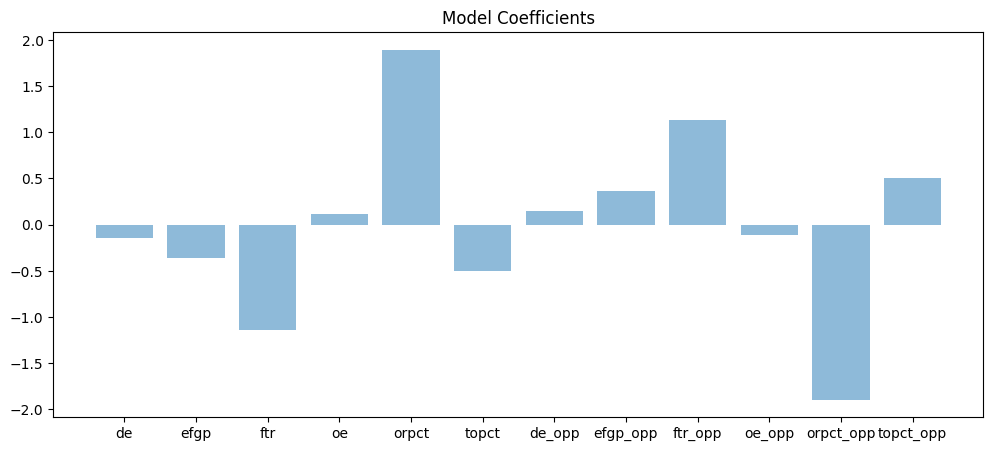

In [245]:

plt.figure(figsize=(12,5))
predictors = ('de', 'efgp', 'ftr', 'oe', 'orpct', 'topct', 'de_opp', 'efgp_opp', 'ftr_opp', 'oe_opp', 'orpct_opp', 'topct_opp')
y_pos = np.arange(len(predictors))
model_coeff = model.coef_.tolist()[0]
 
plt.bar(y_pos, model_coeff, align='center', alpha=0.5, )
plt.xticks(y_pos, predictors)
plt.title('Model Coefficients')
 
plt.show()

In [246]:

C = {'C':[0.1, 1, 10 ,100, 10000, 1000000, 10000000]}
log_model = LogisticRegression(penalty='l2')
clf = GridSearchCV(estimator=log_model, param_grid=C, cv=3, scoring='accuracy')

#Train the model
clf_train = clf.fit(X_train, y_train)

#Predict
clf_pred = clf.predict(X_test)

#Best value of C
print ('Best accuracy of the model:', clf.best_score_) 
print ('Best C:',clf.best_estimator_.C)

Best accuracy of the model: 0.681227863046
Best C: 10000


In [247]:
# probability estimates from cross validation model
win_prob = pd.Series(clf.predict_proba(X_test)[:,1])

In [248]:
test_new = test.reset_index()

In [249]:
test_new['win_prob'] = win_prob

In [250]:
test_new = test_new[['team','opp','win_prob','result']]
test_final = pd.merge(test_new,test_new,left_on = ['team','opp'], right_on = ['opp','team'],how = 'left', 
         suffixes = ('_team','_opp'))

In [251]:
test_final[:5]

,team_team,opp_team,win_prob_team,result_team,team_opp,opp_opp,win_prob_opp,result_opp
0,1195,1192,0.720273,1,1192,1195,0.279721,0
1,1455,1435,0.764622,1,1435,1455,0.235255,0
2,1221,1380,0.240624,1,1380,1221,0.759330,0
3,1276,1409,0.603964,1,1409,1276,0.396004,0
4,1114,1345,0.341908,1,1345,1114,0.658023,0


In [252]:
test_final['pred_result'] = 0.0
test_final['pred_result'][test_final['win_prob_team'] > test_final['win_prob_opp']] = 1.0

C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [253]:
test_final['check'] = test_final['result_team']!=test_final['pred_result']
test_final['check'].value_counts()/2

False    47.0
True     20.0
Name: check, dtype: float64

## Random Forest 1

In [393]:
formula = 'result ~ 0 + de + efgp + ftr + oe + orpct + topct + de_opp + efgp_opp + ftr_opp + oe_opp + orpct_opp + topct_opp'

In [394]:
Y_train, X_train = dmatrices(formula, train, return_type='dataframe')
y_train = Y_train['result'].values


Y_test, X_test = dmatrices(formula, test, return_type='dataframe')
y_test = Y_test['result'].values

In [418]:
model = RandomForestClassifier(max_depth = 4, n_estimators = 300)
result = model.fit(X_train, y_train)

In [419]:
prediction_train = model.predict(X_train)
print (metrics.accuracy_score(y_train, prediction_train))

0.741440377804


In [420]:
prediction = model.predict(X_test)
print (metrics.accuracy_score(y_test, prediction))

0.626865671642


In [307]:
# returns all probability estimates
probs = model.predict_proba(X_test)
probs

array([[ 0.5,  0.5],
       [ 0.2,  0.8],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.7,  0.3],
       [ 0.4,  0.6],
       [ 0.4,  0.6],
       [ 0.4,  0.6],
       [ 0.1,  0.9],
       [ 0.3,  0.7],
       [ 0.7,  0.3],
       [ 0.4,  0.6],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.2,  0.8],
       [ 0.7,  0.3],
       [ 0.6,  0.4],
       [ 0.3,  0.7],
       [ 0.6,  0.4],
       [ 0.3,  0.7],
       [ 0.5,  0.5],
       [ 0.2,  0.8],
       [ 0.7,  0.3],
       [ 0.8,  0.2],
       [ 0.7,  0.3],
       [ 0.6,  0.4],
       [ 0.6,  0.4],
       [ 0.3,  0.7],
       [ 0.8,  0.2],
       [ 0.4,  0.6],
       [ 0.7,  0.3],
       [ 0. ,  1. ],
       [ 0.4,  0.6],
       [ 0.3,  0.7],
       [ 0.8,  0.2],
       [ 0.4,  0.6],
       [ 0.7,  0.3],
       [ 0. ,  1. ],
       [ 0.4,  0.6],
       [ 0.5,  0.5],
       [ 0.3,  0.7],
       [ 0.5,  0.5],
       [ 0.3,  0.7],
       [ 0.3,  0.7],
       [ 0.8,  0.2],
       [ 0.7,  0.3],
       [ 0.5,  0.5],
       [ 0.5,

Feature ranking:
1. feature 6 (0.108210)
2. feature 4 (0.093566)
3. feature 10 (0.092847)
4. feature 0 (0.090329)
5. feature 9 (0.085202)
6. feature 3 (0.081519)
7. feature 7 (0.080942)
8. feature 5 (0.080672)
9. feature 11 (0.076881)
10. feature 1 (0.075932)
11. feature 2 (0.068479)
12. feature 8 (0.065422)


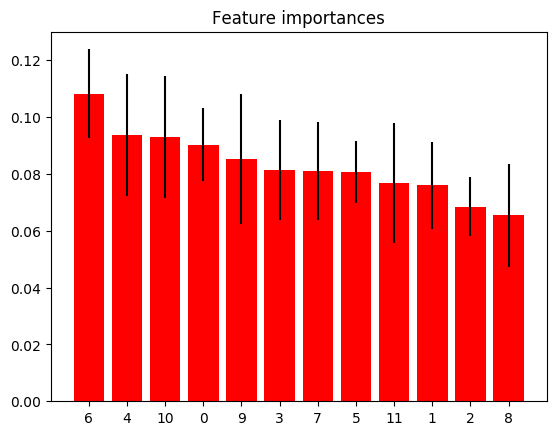

In [308]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Logit Model 2

In [254]:
train['oor'] = train['or'] #needed because 'or' won't work in a formula
test['oor'] = test['or']
formula = 'result ~ 0 + Result + ast + blk + diff + dr + fga + fgm + fgm3 + fgp + fgp3 + fta + ftm + ftp + oppscore + oor + pf + score + stl + to + tr + Result_opp + ast_opp + blk_opp + diff_opp + dr_opp + fga_opp + fgm_opp + fgm3_opp + fgp_opp + fgp3_opp + fta_opp + ftm_opp + ftp_opp + oppscore_opp + or_opp + pf_opp + score_opp + stl_opp + to_opp + tr_opp + de + efgp + ftr + oe + orpct + topct + de_opp + efgp_opp + ftr_opp + oe_opp + orpct_opp + topct_opp'

C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [255]:
Y_train, X_train = dmatrices(formula, train, return_type='dataframe')
y_train = Y_train['result'].values


Y_test, X_test = dmatrices(formula, test, return_type='dataframe')
y_test = Y_test['result'].values

In [256]:
model = LogisticRegression()
result = model.fit(X_train, y_train)

In [257]:
prediction_train = model.predict(X_train)
print (metrics.accuracy_score(y_train, prediction_train))

0.687131050767


In [258]:
prediction = model.predict(X_test)
print (metrics.accuracy_score(y_test, prediction))

0.701492537313


In [259]:
# returns all probability estimates
probs = model.predict_proba(X_test)
probs

array([[ 0.32586232,  0.67413768],
       [ 0.25642471,  0.74357529],
       [ 0.79612308,  0.20387692],
       [ 0.31812952,  0.68187048],
       [ 0.66808834,  0.33191166],
       [ 0.19013645,  0.80986355],
       [ 0.18659963,  0.81340037],
       [ 0.26060798,  0.73939202],
       [ 0.22390687,  0.77609313],
       [ 0.23635403,  0.76364597],
       [ 0.34481489,  0.65518511],
       [ 0.05172009,  0.94827991],
       [ 0.37285961,  0.62714039],
       [ 0.09667337,  0.90332663],
       [ 0.06286706,  0.93713294],
       [ 0.59591666,  0.40408334],
       [ 0.30074055,  0.69925945],
       [ 0.0692902 ,  0.9307098 ],
       [ 0.45941924,  0.54058076],
       [ 0.39269406,  0.60730594],
       [ 0.50453685,  0.49546315],
       [ 0.16234423,  0.83765577],
       [ 0.33302578,  0.66697422],
       [ 0.946753  ,  0.053247  ],
       [ 0.57364315,  0.42635685],
       [ 0.40219609,  0.59780391],
       [ 0.43050055,  0.56949945],
       [ 0.03596008,  0.96403992],
       [ 0.40344144,

In [262]:
model.coef_

array([[-0.10214297, -0.06733966,  0.08514576,  0.23243328, -0.18120571,
        -0.05420749,  0.0469788 , -0.06369519, -0.0086903 , -0.50806082,
        -0.15465758,  0.10249352, -0.00165007, -0.09967735,  0.18534628,
        -0.01882093,  0.13275592, -0.00661249,  0.03659205,  0.00414058,
         0.1021432 ,  0.06733972, -0.08514581, -0.23243354,  0.18120564,
         0.05420739, -0.04697888,  0.06369523,  0.00869031,  0.50806081,
         0.15465746, -0.10249346,  0.00165007,  0.09967754, -0.18534613,
         0.01882099, -0.13275599,  0.00661239, -0.03659208, -0.00414049,
         0.08383554, -0.00823847, -0.17202416, -0.12523071,  0.0312472 ,
         0.001134  , -0.08383586,  0.00823848,  0.17202417,  0.12523099,
        -0.03124719, -0.001134  ]])

## Random Forest 2

In [371]:
train['oor'] = train['or'] #needed because 'or' won't work in a formula
test['oor'] = test['or']
formula = 'result ~ 0 + Result + ast + blk + diff + dr + fga + fgm + fgm3 + fgp + fgp3 + fta + ftm + ftp + oppscore + oor + pf + score + stl + to + tr + Result_opp + ast_opp + blk_opp + diff_opp + dr_opp + fga_opp + fgm_opp + fgm3_opp + fgp_opp + fgp3_opp + fta_opp + ftm_opp + ftp_opp + oppscore_opp + or_opp + pf_opp + score_opp + stl_opp + to_opp + tr_opp + de + efgp + ftr + oe + orpct + topct + de_opp + efgp_opp + ftr_opp + oe_opp + orpct_opp + topct_opp'

C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\cslun\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [372]:
Y_train, X_train = dmatrices(formula, train, return_type='dataframe')
y_train = Y_train['result'].values


Y_test, X_test = dmatrices(formula, test, return_type='dataframe')
y_test = Y_test['result'].values

In [390]:
model = RandomForestClassifier(max_depth = 6, n_estimators = 200)
result = model.fit(X_train, y_train)

In [391]:
prediction_train = model.predict(X_train)
print (metrics.accuracy_score(y_train, prediction_train))

0.863046044864


In [392]:
prediction = model.predict(X_test)
print (metrics.accuracy_score(y_test, prediction))

0.686567164179


In [291]:
# returns all probability estimates
probs = model.predict_proba(X_test)
probs

array([[ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.2,  0.8],
       [ 0.3,  0.7],
       [ 0.6,  0.4],
       [ 0.4,  0.6],
       [ 0.6,  0.4],
       [ 0.5,  0.5],
       [ 0.3,  0.7],
       [ 0.3,  0.7],
       [ 0.3,  0.7],
       [ 0.2,  0.8],
       [ 0.3,  0.7],
       [ 0.3,  0.7],
       [ 0.4,  0.6],
       [ 0.3,  0.7],
       [ 0. ,  1. ],
       [ 0.3,  0.7],
       [ 0.6,  0.4],
       [ 0.7,  0.3],
       [ 0.4,  0.6],
       [ 0.5,  0.5],
       [ 0.2,  0.8],
       [ 0.8,  0.2],
       [ 0.1,  0.9],
       [ 0.6,  0.4],
       [ 0.3,  0.7],
       [ 0.1,  0.9],
       [ 0.4,  0.6],
       [ 0.4,  0.6],
       [ 0.5,  0.5],
       [ 0.2,  0.8],
       [ 0.4,  0.6],
       [ 0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.1,  0.9],
       [ 0.9,  0.1],
       [ 0.4,  0.6],
       [ 0.6,  0.4],
       [ 0.6,  0.4],
       [ 0.2,  0.8],
       [ 0.4,  0.6],
       [ 0.3,  0.7],
       [ 0.6,  0.4],
       [ 0.6,  0.4],
       [ 0.5,  0.5],
       [ 0.4,  0.6],
       [ 0.2,

In [292]:
model.feature_importances_

array([ 0.03979573,  0.01684964,  0.01827557,  0.04633822,  0.01302055,
        0.01423897,  0.03007441,  0.01564112,  0.01965102,  0.01475611,
        0.01115876,  0.0144131 ,  0.01378051,  0.01780544,  0.01290674,
        0.02542859,  0.01772652,  0.01835333,  0.0132315 ,  0.01429555,
        0.04036277,  0.01501528,  0.01936499,  0.05015287,  0.01570748,
        0.01726716,  0.02263691,  0.0174684 ,  0.01549451,  0.02521773,
        0.01522078,  0.01185954,  0.01594935,  0.01554963,  0.01759171,
        0.01520602,  0.01717211,  0.01386447,  0.02178379,  0.01730249,
        0.01770229,  0.01436171,  0.02024488,  0.01873344,  0.01983386,
        0.01280984,  0.02624246,  0.01516964,  0.01777882,  0.01711388,
        0.01818524,  0.01389456])

Feature ranking:
1. feature 23 (0.050153)
2. feature 3 (0.046338)
3. feature 20 (0.040363)
4. feature 0 (0.039796)
5. feature 6 (0.030074)
6. feature 46 (0.026242)
7. feature 15 (0.025429)
8. feature 29 (0.025218)
9. feature 26 (0.022637)
10. feature 38 (0.021784)
11. feature 42 (0.020245)
12. feature 44 (0.019834)
13. feature 8 (0.019651)
14. feature 22 (0.019365)
15. feature 43 (0.018733)
16. feature 17 (0.018353)
17. feature 2 (0.018276)
18. feature 50 (0.018185)
19. feature 13 (0.017805)
20. feature 48 (0.017779)
21. feature 16 (0.017727)
22. feature 40 (0.017702)
23. feature 34 (0.017592)
24. feature 27 (0.017468)
25. feature 39 (0.017302)
26. feature 25 (0.017267)
27. feature 36 (0.017172)
28. feature 49 (0.017114)
29. feature 1 (0.016850)
30. feature 32 (0.015949)
31. feature 24 (0.015707)
32. feature 7 (0.015641)
33. feature 33 (0.015550)
34. feature 28 (0.015495)
35. feature 30 (0.015221)
36. feature 35 (0.015206)
37. feature 47 (0.015170)
38. feature 21 (0.015015)
39. feature

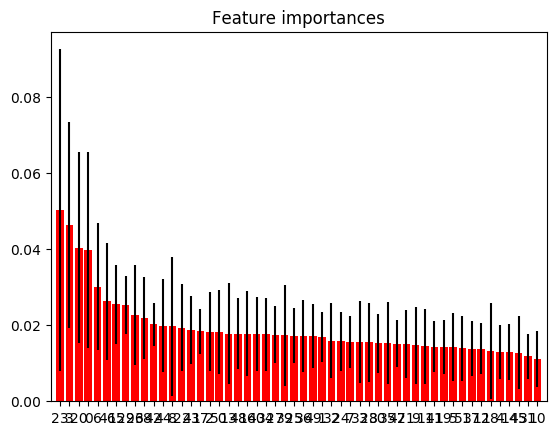

In [293]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [294]:
X_train.columns.values[10]

'fta'